In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Plots, Statistics, Unzip
using JLD2

[ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]


In [2]:
function run_bp(N::Integer; generic::Bool=false,
        tol = 0.0, M = 5)
    T = 10
    λ = 0.2
    ρ = 0.1
    γ = fill(0.05, N)

    sis = SIS(IndexedGraph(star_graph(N)), λ, ρ, T; γ)

    # set up MPBP computation
    bp_ = mpbp(sis)
    
    bp = if generic 
        mpbp(bp_.g, [GenericFactor.(wᵢ) for wᵢ in bp_.w], fill(2, N), T; ϕ=bp_.ϕ)
    else
        bp_
    end
    cb = CB_BP(bp, showprogress=false)
    svd_trunc = TruncBond(M)
    iterate!(bp; maxiter=1, svd_trunc, tol, cb)
    t = @timed begin
        iterate!(bp; maxiter=10, svd_trunc, tol, cb);
    end
    p_bp = means((x,i)->x-1, bp)
    return t, p_bp, bp
end

run_bp (generic function with 1 method)

In [3]:
Ns = 3:16
nsamples = 10
M = 5   # bond size
p_rec = []
p_gen = []
out = map(Ns) do N
    println("Size $N")
    push!(p_rec, []); push!(p_gen, [])
    t = map(1:nsamples) do _
        t_recursive, pr = run_bp(N; generic=false, M)
        push!(p_rec[end], pr)
        tr = t_recursive.time
        tg = if N ≤ 7
            t_generic, pg = run_bp(N; generic=true, M)
            push!(p_gen[end], pg)
            t_generic.time
        else
            NaN
        end
        tr, tg 
    end |> unzip
    mean.(t), std.(t) ./ nsamples
end;

Size 3
Size 4
Size 5
Size 6
Size 7
Size 8
Size 9
Size 10
Size 11
Size 12
Size 13
Size 14
Size 15
Size 16


In [4]:
t_rec_avg = [x[1][1] for x in out]
t_rec_std = [x[2][1] for x in out]
t_gen_avg = [x[1][2] for x in out]
t_gen_std = [x[2][2] for x in out];

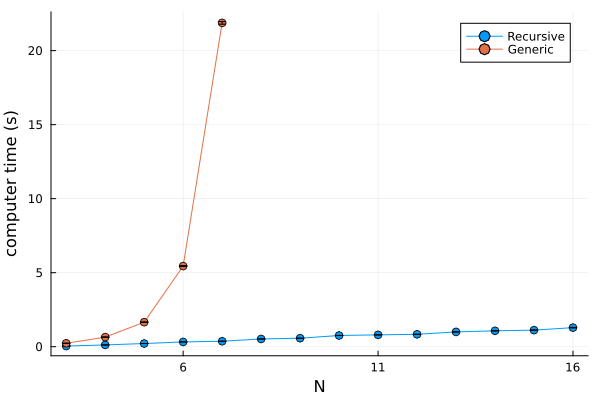

In [5]:
pl = plot(Ns, t_rec_avg, m=:o, label="Recursive", yerr=t_rec_std)
plot!(pl, Ns, t_gen_avg, m=:o, label="Generic", yerr=t_gen_std)
plot(pl, ylabel="computer time (s)", xlabel="N", legend=:topright,
    xticks=1:5:Ns[end])

In [6]:
Ns = 3:16
nsamples = 10
M = 7   # bond size
p_rec2 = []
p_gen2 = []
out = map(Ns) do N
    println("Size $N")
    push!(p_rec2, []); push!(p_gen2, [])
    t = map(1:nsamples) do _
        t_recursive, pr = run_bp(N; generic=false, M)
        push!(p_rec2[end], pr)
        tr = t_recursive.time
        tg = if N ≤ 7
            t_generic, pg = run_bp(N; generic=true, M)
            push!(p_gen2[end], pg)
            t_generic.time
        else
            NaN
        end
        tr, tg 
    end |> unzip
    mean.(t), std.(t) ./ nsamples
end;

Size 3
Size 4
Size 5
Size 6
Size 7
Size 8
Size 9
Size 10
Size 11
Size 12
Size 13
Size 14
Size 15
Size 16


In [13]:
t_rec_avg = [x[1][1] for x in out]
t_rec_std = [x[2][1] for x in out]
t_gen_avg = [x[1][2] for x in out]
t_gen_std = [x[2][2] for x in out];

In [18]:
Ns = 3:16;

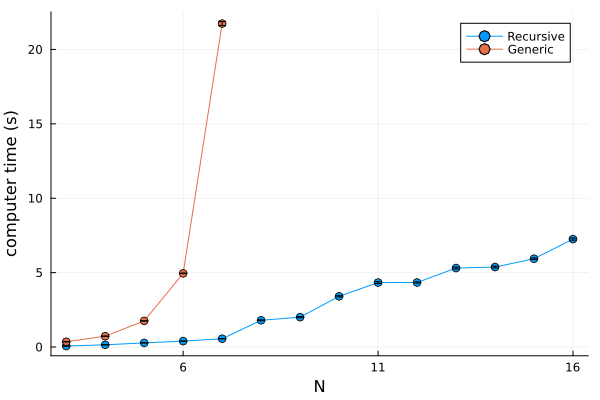

In [20]:
pl = plot(Ns, t_rec_avg, m=:o, label="Recursive", yerr=t_rec_std)
plot!(pl, Ns, t_gen_avg, m=:o, label="Generic", yerr=t_gen_std)
plot(pl, ylabel="computer time (s)", xlabel="N", legend=:topright,
    xticks=1:5:Ns[end])

In [7]:
diffs = map(1:5) do i
    N = Ns[i]
    pr = p_rec[i]
    pg = p_gen[i]
    mean(mean(maximum(abs, pr4 .- pg4 for (pr4,pg4) in zip(pr3, pg3)) 
        for (pr3,pg3) in zip(pr2, pg2)) for (pr2,pg2) in zip(pr, pg))
end
diffs2 = map(1:5) do i
    N = Ns[i]
    pr = p_rec2[i]
    pg = p_gen2[i]
    mean(mean(maximum(abs, pr4 .- pg4 for (pr4,pg4) in zip(pr3, pg3)) 
        for (pr3,pg3) in zip(pr2, pg2)) for (pr2,pg2) in zip(pr, pg))
end;

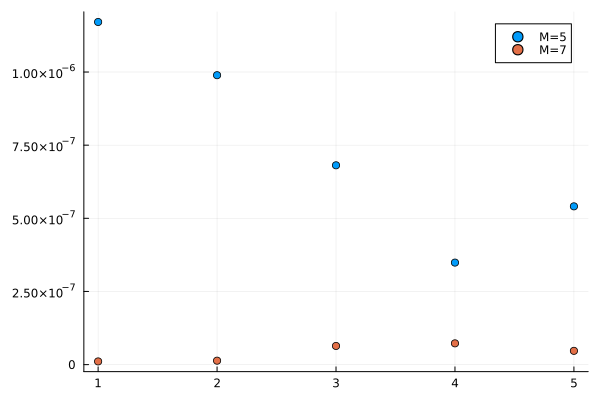

In [8]:
scatter(1:5, diffs, label="M=5")
scatter!(1:5, diffs2, label="M=7")

In [9]:
# jldsave("plot_data/star_graph.jld2"; Ns, t_rec_avg, t_rec_std, t_gen_avg, t_gen_std, 
#     p_gen, p_rec, p_gen2, p_rec2);

## Test maximum degree for BP
Check that it gives reasonable results (no NaNs or other numerical issues) up until very large degree

In [ ]:
Ns = 3:100
nsamples = 10
p_rec = []
t = map(Ns) do N
    println("Size $N")
    push!(p_rec, [])
    t = map(1:nsamples) do _
        t_recursive, pr = run_bp(N; generic=false)
        push!(p_rec[end], pr)
        t_recursive.time
    end
    mean(t), std(t) / nsamples
end |> unzip;

Size 3
Size 4
Size 5
Size 6
Size 7
Size 8
Size 9
Size 10
Size 11
Size 12
Size 13
Size 14
Size 15
Size 16
Size 17
Size 18
Size 19
Size 20
Size 21
Size 22
Size 23
Size 24
Size 25
Size 26
Size 27
Size 28
Size 29
Size 30
Size 31
Size 32
Size 33


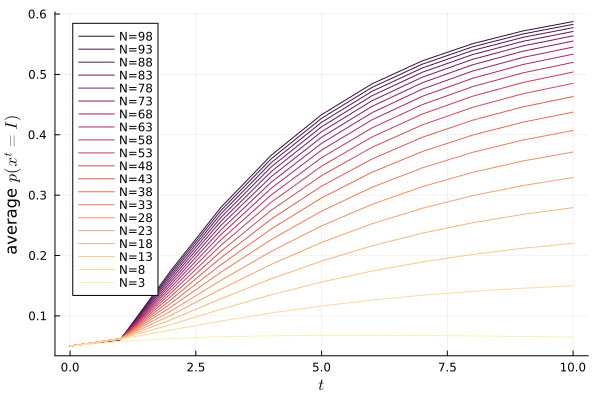

In [12]:
using ColorSchemes, LaTeXStrings
idx = eachindex(Ns)[1:5:end]
cg = cgrad(:matter, length(idx), categorical=true)

pl = plot()
for i in eachindex(idx) |> reverse
    N = Ns[idx[i]]
    pr = mean(mean(p_rec[idx[i]]))
    plot!(pl, eachindex(pr) .- 1, pr, label="N=$N", c=cg[i]) 
end
plot(pl, xlabel=L"t", ylabel="average "*(L"p(x^t=I)"))